In [2]:
!pip install yfinance pandas matplotlib


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta


In [4]:
def to_weekly_close(df: pd.DataFrame, col: str) -> pd.Series:
    """
    Convert daily data to weekly (Friday) closing prices.
    If Friday is missing, uses the last available close in that week.
    """
    s = df[col].dropna()
    s.index = pd.to_datetime(s.index).tz_localize(None)
    return s.resample("W-FRI").last().dropna()


In [5]:
# Yahoo tickers
price_ticker = "CNX1.L"   # iShares CNX1 on LSE (USD)
fx_ticker = "GBPUSD=X"    # USD per 1 GBP

end = datetime.today()
start = end - timedelta(days=370)

# Download daily prices
cnx1_daily = yf.download(
    price_ticker,
    start=start.date(),
    end=end.date(),
    interval="1d",
    progress=False
)

fx_daily = yf.download(
    fx_ticker,
    start=start.date(),
    end=end.date(),
    interval="1d",
    progress=False
)

cnx1_daily.head(), fx_daily.head()


/var/folders/2v/8dp8523d73b_x96ftkvjl6km0000gn/T/ipykernel_67068/4199088715.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  cnx1_daily = yf.download(
/var/folders/2v/8dp8523d73b_x96ftkvjl6km0000gn/T/ipykernel_67068/4199088715.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  fx_daily = yf.download(


(Price          Close           High            Low      Open Volume
 Ticker        CNX1.L         CNX1.L         CNX1.L    CNX1.L CNX1.L
 Date                                                               
 2025-01-16   99343.0  100240.000000   99059.000000  100046.0   5997
 2025-01-17  100716.0  101000.000000   99139.789062   99269.0   4120
 2025-01-20  100275.0  100911.000000   99950.000000  100501.0   7731
 2025-01-21   99708.0  100706.648438   99540.437500  100174.0   3059
 2025-01-22  101709.0  101709.000000  100454.000000  100831.0   3177,
 Price          Close      High       Low      Open   Volume
 Ticker      GBPUSD=X  GBPUSD=X  GBPUSD=X  GBPUSD=X GBPUSD=X
 Date                                                       
 2025-01-16  1.224335  1.224845  1.217700  1.224335        0
 2025-01-17  1.223691  1.224425  1.216249  1.223466        0
 2025-01-20  1.217100  1.232392  1.216663  1.217567        0
 2025-01-21  1.233137  1.234522  1.223197  1.233319        0
 2025-01-22  1.23354

In [10]:
cnx1_usd = to_weekly_close(cnx1_daily, "Close")
gbpusd = to_weekly_close(fx_daily, "Close")

usdgbp = 1.0 / gbpusd  # USD per GBP -> invert to get USD/GBP

# Combine and force column names
weekly = pd.concat([cnx1_usd, usdgbp], axis=1)
weekly.columns = ["CNX1_USD", "USDGBP"]
weekly = weekly.dropna()

weekly.head()


,CNX1_USD,USDGBP
Date,,
2025-01-17,100716.0,0.81720
2025-01-24,100175.5,0.80946
2025-01-31,100295.5,0.80490
2025-02-07,99451.5,0.80402
2025-02-14,100001.0,0.79596


In [11]:
weekly["CNX1_GBP"] = weekly["CNX1_USD"] * weekly["USDGBP"]
weekly.tail()


,CNX1_USD,USDGBP,CNX1_GBP
Date,,,
2025-12-19,108570.0,0.747083,81110.801136
2025-12-26,108650.0,0.740250,80428.164878
2026-01-09,109850.0,0.744158,81745.762368
2026-01-16,109580.0,0.747310,81890.224369
2026-01-23,107590.0,0.745250,80181.449605


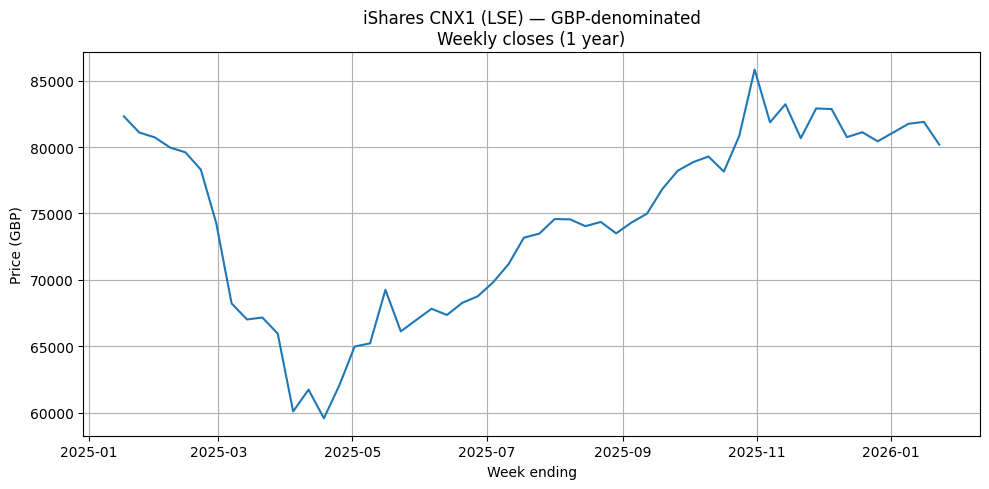

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(weekly.index, weekly["CNX1_GBP"])
plt.title("iShares CNX1 (LSE) — GBP-denominated\nWeekly closes (1 year)")
plt.xlabel("Week ending")
plt.ylabel("Price (GBP)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
import yfinance as yf

yf.Ticker("SMEA.L").info.get("currency")


'GBp'

In [15]:
tickers = {
    "CNX1": "CNX1.L",
    "SMEA": "SMEA.L",
    "CEA1": "CEA1.L",
}

weekly = pd.DataFrame()

for name, ticker in tickers.items():
    df = yf.download(ticker, start=start.date(), end=end.date(), progress=False)
    weekly[name] = to_weekly_close(df, "Close")

weekly = weekly.dropna()


/var/folders/2v/8dp8523d73b_x96ftkvjl6km0000gn/T/ipykernel_67068/2316319481.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start.date(), end=end.date(), progress=False)
/var/folders/2v/8dp8523d73b_x96ftkvjl6km0000gn/T/ipykernel_67068/2316319481.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start.date(), end=end.date(), progress=False)
/var/folders/2v/8dp8523d73b_x96ftkvjl6km0000gn/T/ipykernel_67068/2316319481.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start.date(), end=end.date(), progress=False)


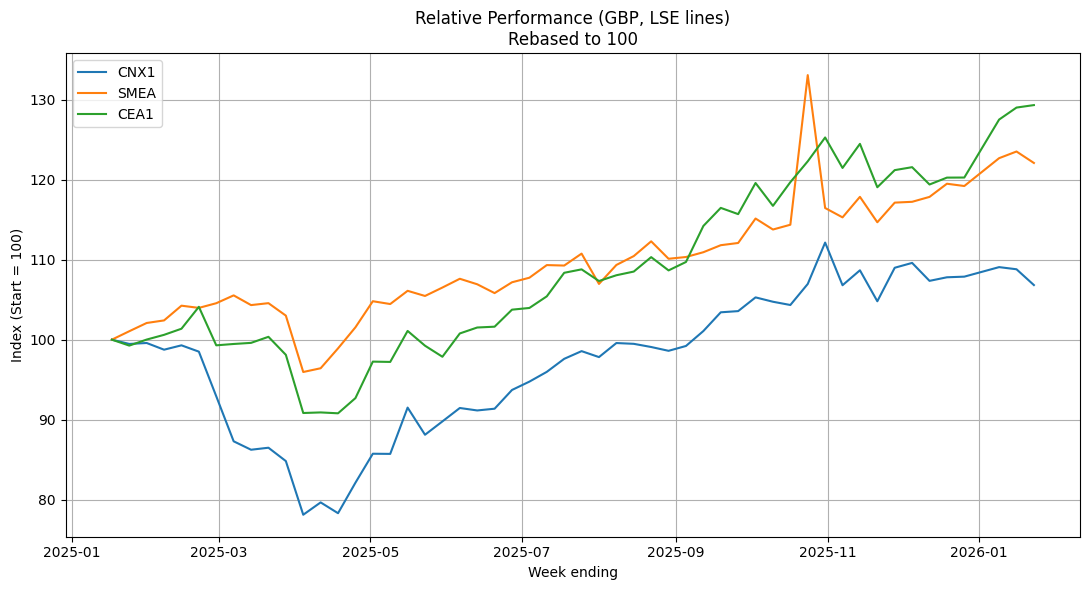

In [16]:
rebased = weekly / weekly.iloc[0] * 100

plt.figure(figsize=(11, 6))
for col in rebased.columns:
    plt.plot(rebased.index, rebased[col], label=col)

plt.title("Relative Performance (GBP, LSE lines)\nRebased to 100")
plt.xlabel("Week ending")
plt.ylabel("Index (Start = 100)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta


In [18]:
def to_weekly(series: pd.Series) -> pd.Series:
    s = series.dropna()
    s.index = pd.to_datetime(s.index).tz_localize(None)
    return s.resample("W-FRI").last().dropna()


In [25]:
def get_weekly_total_return(df: pd.DataFrame) -> pd.Series:
    """
    Returns weekly total return series.
    Prefers Adj Close if available, otherwise falls back to Close
    with a warning.
    """
    # Handle MultiIndex columns
    if isinstance(df.columns, pd.MultiIndex):
        cols = [c[0] for c in df.columns]
        df.columns = cols

    if "Adj Close" in df.columns:
        series = df["Adj Close"]
    else:
        print("⚠️ Adj Close not available, falling back to Close (price return only)")
        series = df["Close"]

    series = series.dropna()
    series.index = pd.to_datetime(series.index).tz_localize(None)
    return series.resample("W-FRI").last().dropna()


In [59]:
tickers = {
    "CNX1": "CNX1.L",
    "IMEU": "IMEU.L",
    "CEA1": "CEA1.L",
    "DJMC": "DJMC.L",
    "IUSA": "IUSA.L",
    "SWDA": "SWDA.L",
    "ISAC": "ISAC.L",
}

end = datetime.today()
start = end - timedelta(days=1800)

weekly_tr = pd.DataFrame()

for name, ticker in tickers.items():
    df = yf.download(ticker, start=start.date(), end=end.date(), progress=False)
    weekly_tr[name] = get_weekly_total_return(df)

weekly_tr = weekly_tr.dropna()
weekly_tr.head()


⚠️ Adj Close not available, falling back to Close (price return only)
⚠️ Adj Close not available, falling back to Close (price return only)
⚠️ Adj Close not available, falling back to Close (price return only)
⚠️ Adj Close not available, falling back to Close (price return only)
⚠️ Adj Close not available, falling back to Close (price return only)
⚠️ Adj Close not available, falling back to Close (price return only)
⚠️ Adj Close not available, falling back to Close (price return only)


/var/folders/2v/8dp8523d73b_x96ftkvjl6km0000gn/T/ipykernel_67068/2029482499.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start.date(), end=end.date(), progress=False)
/var/folders/2v/8dp8523d73b_x96ftkvjl6km0000gn/T/ipykernel_67068/2029482499.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start.date(), end=end.date(), progress=False)
/var/folders/2v/8dp8523d73b_x96ftkvjl6km0000gn/T/ipykernel_67068/2029482499.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start.date(), end=end.date(), progress=False)
/var/folders/2v/8dp8523d73b_x96ftkvjl6km0000gn/T/ipykernel_67068/2029482499.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start.date(), end=end.date(), progress=False)
/var/folders/2v/8dp8523d73b_x96ftkvjl6km

,CNX1,IMEU,CEA1,DJMC,IUSA,SWDA,ISAC
Date,,,,,,,
2021-02-19,55069.5,2199.532959,16162.0,5629.995605,2793.831299,5488.0,67.400002
2021-02-26,52560.0,2151.098145,15088.0,5533.125000,2736.239990,5354.5,65.190002
2021-03-05,49960.5,2165.080078,14897.0,5533.125000,2697.763672,5286.5,63.750000
2021-03-12,52064.5,2232.488770,14969.5,5690.451660,2806.409668,5493.0,66.449997
2021-03-19,52260.0,2228.494385,14977.5,5687.457031,2810.532471,5514.0,66.459999


In [60]:
rebased_tr = weekly_tr / weekly_tr.iloc[0] * 100
rebased_tr.head()


,CNX1,IMEU,CEA1,DJMC,IUSA,SWDA,ISAC
Date,,,,,,,
2021-02-19,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2021-02-26,95.443031,97.797950,93.354783,98.279384,97.938626,97.567420,96.721070
2021-03-05,90.722632,98.433627,92.172998,98.279384,96.561438,96.328353,94.584568
2021-03-12,94.543259,101.498309,92.621581,101.073821,100.450219,100.091108,98.590498
2021-03-19,94.898265,101.316708,92.671080,101.020630,100.597787,100.473761,98.605338


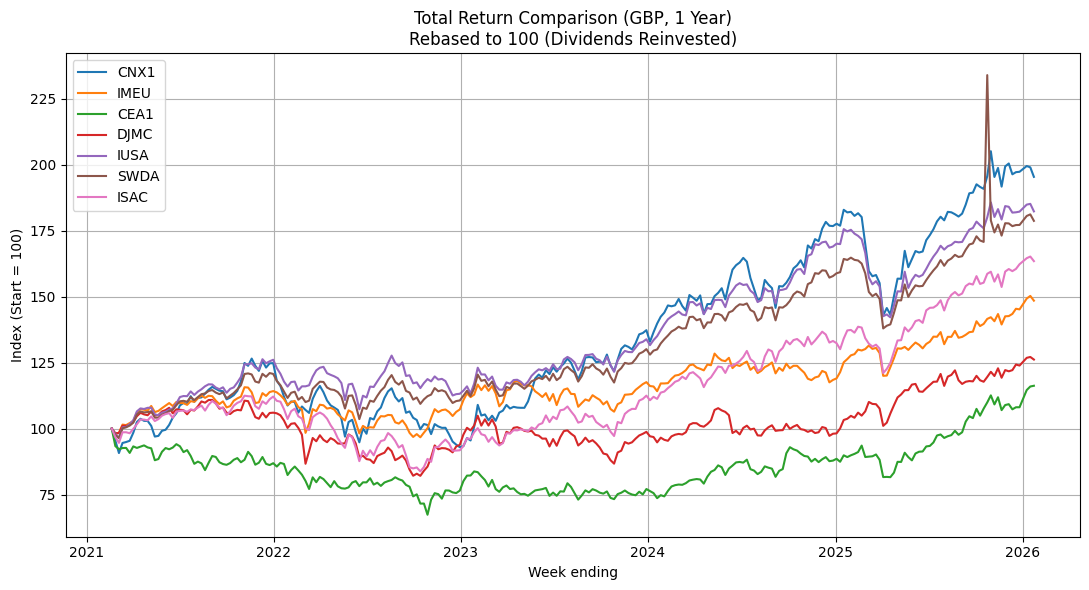

In [61]:
plt.figure(figsize=(11, 6))

for col in rebased_tr.columns:
    plt.plot(rebased_tr.index, rebased_tr[col], label=col)

plt.title("Total Return Comparison (GBP, 1 Year)\nRebased to 100 (Dividends Reinvested)")
plt.xlabel("Week ending")
plt.ylabel("Index (Start = 100)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [24]:
t = yf.Ticker("DJMC.L")
t.dividends.tail(10)


Date
2023-09-14 00:00:00+01:00     43.916600
2023-12-14 00:00:00+00:00     11.950399
2024-03-14 00:00:00+00:00      6.200500
2024-06-13 00:00:00+01:00    105.845900
2024-09-12 00:00:00+01:00     48.766900
2024-12-12 00:00:00+00:00     29.077800
2025-03-13 00:00:00+00:00      6.274601
2025-06-12 00:00:00+01:00    143.689800
2025-09-11 00:00:00+01:00     51.406403
2025-12-11 00:00:00+00:00     18.901900
Name: Dividends, dtype: float64

In [45]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta


In [46]:
def to_weekly(series: pd.Series) -> pd.Series:
    series = series.dropna()
    series.index = pd.to_datetime(series.index).tz_localize(None)
    return series.resample("W-FRI").last().dropna()


In [47]:
tickers = {
    "CNX1": "CNX1.L",
    "IMEU": "IMEU.L",
    "DJMC": "DJMC.L",
    "IUSA": "IUSA.L",
    "CEA1": "CEA1.L",
}

weights = {
    "CNX1": 0.225,
    "IMEU": 0.225,
    "DJMC": 0.225,
    "IUSA": 0.225,
    "CEA1": 0.10,
}

assert abs(sum(weights.values()) - 1.0) < 1e-6


In [48]:
LOOKBACK_DAYS = 3700
end = datetime.today()
start = end - timedelta(days=LOOKBACK_DAYS)


In [49]:
weekly_prices = pd.DataFrame()

for name, ticker in tickers.items():
    df = yf.download(
        ticker,
        start=start.date(),
        end=end.date(),
        auto_adjust=True,   # dividends + splits
        progress=False
    )
    weekly_prices[name] = to_weekly(df["Close"])

weekly_prices = weekly_prices.dropna()
weekly_prices.head()


,CNX1,IMEU,DJMC,IUSA,CEA1
Date,,,,,
2015-12-11,16431.5,1595.300903,3513.269775,1322.302856,6631.0
2015-12-18,16750.5,1629.704956,3577.110596,1348.391724,6968.5
2015-12-25,16905.5,1665.105957,3644.942139,1371.609863,7098.5
2016-01-01,17123.5,1669.095215,3658.408447,1381.096313,7058.0
2016-01-08,16187.0,1585.577637,3497.808350,1325.922485,6609.5


In [50]:
weekly_returns = weekly_prices.pct_change().dropna()
weekly_returns.head()


,CNX1,IMEU,DJMC,IUSA,CEA1
Date,,,,,
2015-12-18,0.019414,0.021566,0.018171,0.019730,0.050897
2015-12-25,0.009253,0.021722,0.018963,0.017219,0.018655
2016-01-01,0.012895,0.002396,0.003695,0.006916,-0.005705
2016-01-08,-0.054691,-0.050038,-0.043899,-0.039949,-0.063545
2016-01-15,-0.021221,-0.016195,-0.021104,-0.015627,-0.020728


In [51]:
# Find the rebalance anchor: week containing Jan 23
year = weekly_returns.index[0].year
jan_23 = pd.Timestamp(year=year, month=1, day=23)

# First rebalance = end of that week (Friday)
first_rebalance = weekly_returns.index[
    weekly_returns.index >= jan_23
][0]

# Rebalance every 13 weeks
rebalance_dates = weekly_returns.index[
    (weekly_returns.index >= first_rebalance) &
    ((weekly_returns.index - first_rebalance).days % (13 * 7) == 0)
]

rebalance_dates[:5]


DatetimeIndex(['2015-12-18', '2016-03-18', '2016-06-17', '2016-09-16',
               '2016-12-16'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [52]:
portfolio_value = pd.Series(index=weekly_returns.index, dtype=float)
portfolio_value.iloc[0] = 100.0

current_weights = pd.Series(weights)

for i in range(1, len(weekly_returns)):
    date = weekly_returns.index[i]

    # Apply returns
    portfolio_value.iloc[i] = portfolio_value.iloc[i-1] * (
        1 + (weekly_returns.iloc[i] * current_weights).sum()
    )

    # Rebalance if needed
    if date in rebalance_dates:
        current_weights = pd.Series(weights)


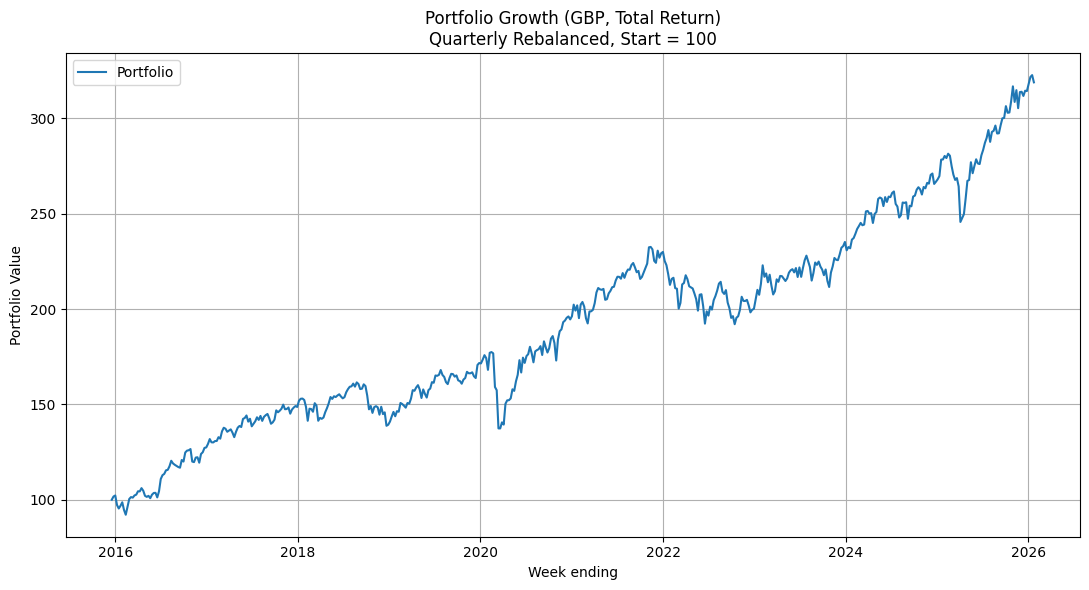

In [53]:
plt.figure(figsize=(11, 6))
plt.plot(portfolio_value.index, portfolio_value, label="Portfolio")
plt.title("Portfolio Growth (GBP, Total Return)\nQuarterly Rebalanced, Start = 100")
plt.xlabel("Week ending")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
